
# Hierarchical Models

**partial pooling, shrinkage, and hierarchical regression**

## Utilities

In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

def with_ax(title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    return fig, ax

def invgamma_rvs(alpha, beta, size=1, rng=None):
    if rng is None: rng = np.random.default_rng()
    return 1.0 / rng.gamma(shape=alpha, scale=1.0/beta, size=size)

def hdi_interval(samples, prob=0.9):
    x = np.sort(np.asarray(samples))
    n = len(x)
    m = max(1, int(np.floor(prob * n)))
    widths = x[m:] - x[:n-m]
    j = int(np.argmin(widths))
    return float(x[j]), float(x[j+m])



## Probabilistic graphical models for grouped data

We use plates to show repeated structure (groups and observations) and distinguish between
observed and latent variables. Hierarchical models add **hyperpriors** on group-level parameters.



## Cancer-rate style example: complete vs no pooling vs partial pooling

We simulate a dataset with counties nested in states (unequal counties per state).
Let $y_{ij}$ be the cancer rate (per 100k) for county $i$ in state $j$.


In [2]:

# Simulate true state means and county observations
J = 30                                      # states
n_j = rng.integers(3, 20, size=J)           # counties per state
mu_global = 440.0
tau_true = 25.0                             # between-state SD
sigma_y_true = 35.0                         # within-state SD

mu_j_true = rng.normal(mu_global, tau_true, size=J)
y = []
state_id = []
for j in range(J):
    yj = rng.normal(mu_j_true[j], sigma_y_true, size=n_j[j])
    y.append(yj)
    state_id += [j]*len(yj)
y = np.concatenate(y)
state_id = np.array(state_id)
J, n_j.min(), n_j.max(), y.mean()


(30, 3, 19, 423.620297960669)


### Complete pooling

Ignore states and fit a single Normal model for all counties:
$$
y_{ij} \sim \mathcal{N}(\mu,\ \sigma_y^2).
$$
We use a weak Normal–Inverse-Gamma prior and compute the posterior.


In [3]:

def nig_posterior(y, m0=0.0, k0=1e-6, a0=2.0, b0=1.0):
    n = len(y)
    ybar = float(np.mean(y))
    s2 = float(np.sum((y - ybar)**2))
    kn = k0 + n
    mn = (k0*m0 + n*ybar)/kn
    an = a0 + n/2
    bn = b0 + 0.5*s2 + 0.5*(k0*n/kn)*(ybar - m0)**2
    return mn, kn, an, bn

def sample_nig(mn, kn, an, bn, draws=5000, rng=None):
    if rng is None: rng = np.random.default_rng()
    sigma2 = 1.0 / rng.gamma(shape=an, scale=1.0/bn, size=draws)
    mu = rng.normal(mn, np.sqrt(sigma2/kn), size=draws)
    return mu, sigma2

mn_all, kn_all, an_all, bn_all = nig_posterior(y, m0=400.0, k0=1e-4, a0=2.0, b0=1000.0)
mu_all_samps, s2_all_samps = sample_nig(mn_all, kn_all, an_all, bn_all, draws=20_000, rng=rng)
float(mu_all_samps.mean()), hdi_interval(mu_all_samps, 0.94)


(423.6252404947927, (419.56716492520405, 427.7679380730083))


### No pooling (separate per-state models)

Fit independent models per state:
$$
y_{ij} \sim \mathcal{N}(\mu_j,\ \sigma_{y,j}^2),
$$
each with its own Normal–Inverse-Gamma prior.


In [4]:

def per_state_nig(y, state_id):
    J = int(state_id.max()+1)
    post = []
    for j in range(J):
        yj = y[state_id==j]
        mn,kn,an,bn = nig_posterior(yj, m0=400.0, k0=1e-4, a0=2.0, b0=1000.0)
        post.append((mn,kn,an,bn,len(yj)))
    return post

post_sep = per_state_nig(y, state_id)
# Extract posterior means for mu_j to visualize
mu_j_sep_mean = np.array([sample_nig(*ps[:4], draws=5000, rng=rng)[0].mean() for ps in post_sep])
len(mu_j_sep_mean), float(mu_j_sep_mean.mean())


(30, 425.416969589516)


### Partial pooling (hierarchical Normal)

Model:
$$
\begin{aligned}
y_{ij} &\sim \mathcal{N}(\mu_j,\ \sigma_y^2),\\
\mu_j &\sim \mathcal{N}(\mu,\ \tau^2),\\
\mu &\sim \mathcal{N}(m_0,\ s_0^2),\\
\sigma_y^2 &\sim \mathrm{InvGamma}(a_y,b_y),\qquad
\tau^2 \sim \mathrm{InvGamma}(a_\tau,b_\tau).
\end{aligned}
$$

We implement a simple Gibbs sampler.


In [5]:

def gibbs_normal_hier(y, state_id, iters=6000, burn=1000, thin=2, seed=0):
    rng = np.random.default_rng(seed)
    J = int(state_id.max()) + 1
    groups = [np.where(state_id==j)[0] for j in range(J)]
    n_j = np.array([len(g) for g in groups])
    ybar_j = np.array([y[g].mean() for g in groups])

    # Hyperpriors
    m0, s0 = 400.0, 100.0
    a_y, b_y = 2.0, 1000.0
    a_t, b_t = 2.0, 400.0

    # Init
    mu = y.mean()
    tau2 = np.var(ybar_j)
    sigma2 = np.var(y)
    mu_j = ybar_j.copy()

    kept = []
    for t in range(iters):
        # Update mu_j | rest
        for j in range(J):
            prec = n_j[j]/sigma2 + 1.0/tau2
            mean = (n_j[j]*ybar_j[j]/sigma2 + mu/tau2) / prec
            sd = math.sqrt(1.0/prec)
            mu_j[j] = rng.normal(mean, sd)

        # Update mu | rest
        prec = J/tau2 + 1.0/(s0**2)
        mean = (mu_j.sum()/tau2 + m0/(s0**2)) / prec
        mu = rng.normal(mean, math.sqrt(1.0/prec))

        # Update sigma2 | rest
        ay = a_y + 0.5*np.sum(n_j)
        by = b_y + 0.5*sum(((y[groups[j]] - mu_j[j])**2).sum() for j in range(J))
        sigma2 = invgamma_rvs(ay, by, size=1, rng=rng)[0]

        # Update tau2 | rest
        at = a_t + 0.5*J
        bt = b_t + 0.5*np.sum((mu_j - mu)**2)
        tau2 = invgamma_rvs(at, bt, size=1, rng=rng)[0]

        if t>=burn and ((t-burn)%thin==0):
            kept.append((mu, tau2, sigma2, mu_j.copy()))
    arr = np.array([ (k[0],k[1],k[2]) for k in kept ])
    mu_draws, tau2_draws, sigma2_draws = arr[:,0], arr[:,1], arr[:,2]
    mu_j_draws = np.array([k[3] for k in kept])  # draws x J
    return mu_draws, tau2_draws, sigma2_draws, mu_j_draws

mu_draws, tau2_draws, sigma2_draws, mu_j_draws = gibbs_normal_hier(y, state_id, iters=9000, burn=3000, thin=2, seed=11)
float(mu_draws.mean()), float(np.mean(mu_j_draws, axis=0).mean())


(424.89788322612884, 424.99441050601786)

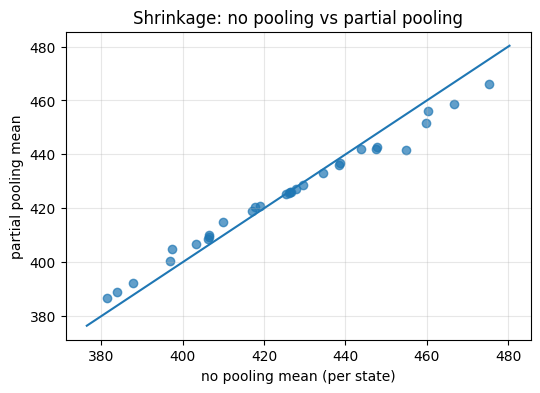

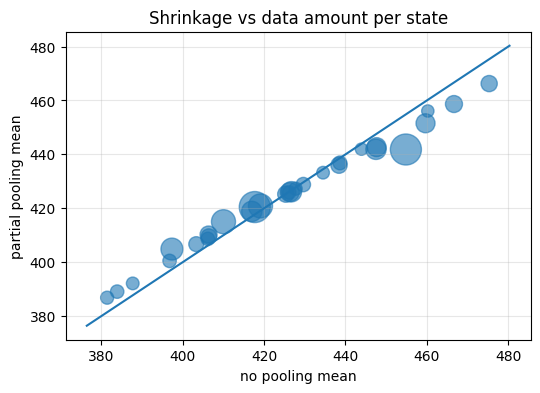

In [6]:

# Visualize shrinkage: raw state means vs partial pooling posterior means
raw_means = np.array([y[state_id==j].mean() for j in range(int(state_id.max()+1))])
pp_means = np.mean(mu_j_draws, axis=0)

fig, ax = with_ax(title="Shrinkage: no pooling vs partial pooling", xlabel="no pooling mean (per state)", ylabel="partial pooling mean")
ax.scatter(raw_means, pp_means, alpha=0.7)
lims = [min(raw_means.min(), pp_means.min())-5, max(raw_means.max(), pp_means.max())+5]
ax.plot(lims, lims)
plt.show()

# States with few counties shrink more: visualize by point size inverse to n_j
J = int(state_id.max()+1)
n_j = np.array([np.sum(state_id==j) for j in range(J)])
fig, ax = with_ax(title="Shrinkage vs data amount per state", xlabel="no pooling mean", ylabel="partial pooling mean")
sizes = (1.0/n_j)*1500
ax.scatter(raw_means, pp_means, s=sizes, alpha=0.6)
ax.plot(lims, lims); plt.show()



### Prediction for new counties

- Existing state $j$: draw $\mu_j$ and $\sigma_y^2$ from the posterior, then $y_\text{new}\sim \mathcal{N}(\mu_j,\sigma_y^2)$.  
- New state $j^\*$: draw $\mu\sim p(\mu\mid y)$, $\tau^2\sim p(\tau^2\mid y)$, then $\mu_{j^\*}\sim \mathcal{N}(\mu,\tau^2)$ and $y_\text{new}\sim \mathcal{N}(\mu_{j^\*},\sigma_y^2)$.


In [7]:

def predictive_existing_state(j, mu_j_draws, sigma2_draws, draws=5000, rng=None):
    if rng is None: rng = np.random.default_rng()
    idx = rng.integers(0, len(sigma2_draws), size=draws)
    mu_s = mu_j_draws[idx, j]
    s2_s = sigma2_draws[idx]
    return rng.normal(mu_s, np.sqrt(s2_s))

def predictive_new_state(mu_draws, tau2_draws, sigma2_draws, draws=5000, rng=None):
    if rng is None: rng = np.random.default_rng()
    idx = rng.integers(0, len(sigma2_draws), size=draws)
    mu_s = mu_draws[idx]
    tau2_s = tau2_draws[idx]
    s2_s = sigma2_draws[idx]
    mu_new = rng.normal(mu_s, np.sqrt(tau2_s))
    return rng.normal(mu_new, np.sqrt(s2_s))

j_delaware_like = int(np.argmin([np.sum(state_id==j) for j in range(int(state_id.max()+1))]))  # state with few counties
y_pred_exist = predictive_existing_state(j_delaware_like, mu_j_draws, sigma2_draws, draws=20_000, rng=rng)
y_pred_new   = predictive_new_state(mu_draws, tau2_draws, sigma2_draws, draws=20_000, rng=rng)

hdi_exist = hdi_interval(y_pred_exist, 0.94)
hdi_new   = hdi_interval(y_pred_new,   0.94)
float(np.mean(y_pred_exist)), hdi_exist, float(np.mean(y_pred_new)), hdi_new


(441.6719926433443,
 (372.7517410022381, 509.4566918303516),
 424.9833727649837,
 (351.56611008774235, 502.848392774539))

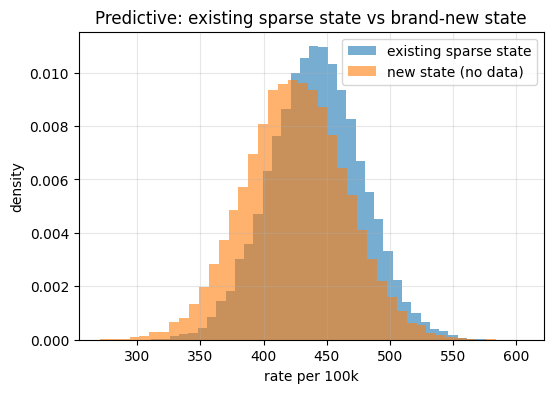

In [8]:

# Plot predictive distributions
fig, ax = with_ax(title="Predictive: existing sparse state vs brand-new state", xlabel="rate per 100k", ylabel="density")
ax.hist(y_pred_exist, bins=40, density=True, alpha=0.6, label="existing sparse state")
ax.hist(y_pred_new, bins=40, density=True, alpha=0.6, label="new state (no data)")
ax.legend(); plt.show()



## Hierarchical linear regression: random intercepts and slopes

We simulate patients $j=1,\dots,J$ with repeated measurements over weeks $t$:
$$
y_{jt} = \beta_{0j} + \beta_{1j}\, t + \varepsilon_{jt},\qquad
\varepsilon_{jt}\sim \mathcal{N}(0,\sigma_y^2).
$$
Group-level priors:
$$
\begin{aligned}
\beta_{0j} &\sim \mathcal{N}(\beta_0,\ \sigma_0^2),\\
\beta_{1j} &\sim \mathcal{N}(\beta_1,\ \sigma_1^2),
\end{aligned}
$$
with hyperpriors on $(\beta_0,\beta_1)$ and variances. We implement a simple Gibbs sampler.


In [9]:

# Simulate patient trajectories (FVC-like)
J = 18
Tj = rng.integers(6, 14, size=J)   # measurements per patient
beta0_true = rng.normal(3.0, 0.7, size=J)   # liters
beta1_true = rng.normal(-0.04, 0.02, size=J)  # liters per week
sigma_y_true = 0.12
t_list = []
y_list = []
pid_list = []
for j in range(J):
    t = np.sort(rng.integers(0, 60, size=Tj[j]))
    yj = beta0_true[j] + beta1_true[j]*t + rng.normal(0, sigma_y_true, size=Tj[j])
    t_list.append(t); y_list.append(yj); pid_list += [j]*Tj[j]
t = np.concatenate(t_list).astype(float)
yobs = np.concatenate(y_list).astype(float)
pid = np.array(pid_list)
len(yobs), yobs.mean()


(177, 1.7172532335232846)

In [10]:

def gibbs_random_intercept_slope(t, y, pid, iters=5000, burn=2000, thin=2, seed=0):
    rng = np.random.default_rng(seed)
    J = int(pid.max()+1)
    groups = [np.where(pid==j)[0] for j in range(J)]

    # Hyperpriors
    mB0 = np.array([0.0, 0.0])
    VB0 = np.eye(2)*1e2
    a_y, b_y = 2.0, 0.5
    a0,b0 = 2.0, 0.5
    a1,b1 = 2.0, 0.5

    # Init
    beta = np.array([y.mean(), 0.0])
    sigma2 = 0.5
    s0_2 = 0.5
    s1_2 = 0.01
    Bj = np.zeros((J,2))

    kept = []
    for it in range(iters):
        # Update per-patient Bj | rest
        for j in range(J):
            idx = groups[j]
            tj = t[idx]
            yj = y[idx]
            Xj = np.column_stack([np.ones_like(tj), tj])
            Sj_inv = np.diag([1.0/s0_2, 1.0/s1_2])
            Vj = np.linalg.inv(Sj_inv + (Xj.T @ Xj)/sigma2)
            mj = Vj @ (Sj_inv @ beta + (Xj.T @ yj)/sigma2)
            Lj = np.linalg.cholesky(Vj)
            Bj[j] = mj + Lj @ rng.normal(size=2)

        # Update beta | Bj
        Vb = np.linalg.inv(np.linalg.inv(VB0) + J*np.diag([1.0/s0_2, 1.0/s1_2]))
        mb = Vb @ (np.linalg.inv(VB0) @ mB0 + np.array([Bj[:,0].sum()/s0_2, Bj[:,1].sum()/s1_2]))
        beta = mb + np.linalg.cholesky(Vb) @ rng.normal(size=2)

        # Update sigma2 | rest
        res = 0.0
        for j in range(J):
            idx = groups[j]
            tj = t[idx]
            yj = y[idx]
            res += np.sum((yj - (Bj[j,0] + Bj[j,1]*tj))**2)
        a_post = a_y + 0.5*len(y)
        b_post = b_y + 0.5*res
        sigma2 = invgamma_rvs(a_post, b_post, size=1, rng=rng)[0]

        # Update s0^2 and s1^2 | rest
        a0p = a0 + 0.5*J
        b0p = b0 + 0.5*np.sum((Bj[:,0] - beta[0])**2)
        s0_2 = invgamma_rvs(a0p, b0p, size=1, rng=rng)[0]

        a1p = a1 + 0.5*J
        b1p = b1 + 0.5*np.sum((Bj[:,1] - beta[1])**2)
        s1_2 = invgamma_rvs(a1p, b1p, size=1, rng=rng)[0]

        if it>=burn and ((it-burn)%thin==0):
            kept.append((beta.copy(), s0_2, s1_2, sigma2, Bj.copy()))
    draws = len(kept)
    beta_draws = np.array([k[0] for k in kept])
    s0_draws   = np.array([k[1] for k in kept])
    s1_draws   = np.array([k[2] for k in kept])
    s2_draws   = np.array([k[3] for k in kept])
    Bj_draws   = np.array([k[4] for k in kept])   # draws x J x 2
    return beta_draws, s0_draws, s1_draws, s2_draws, Bj_draws

beta_draws, s0_draws, s1_draws, s2_draws, Bj_draws = gibbs_random_intercept_slope(t, yobs, pid, iters=7000, burn=3000, thin=2, seed=13)
beta_draws.mean(axis=0), float(np.mean(s2_draws))


(array([ 3.14941882, -0.04369272]), 0.021889298786239388)

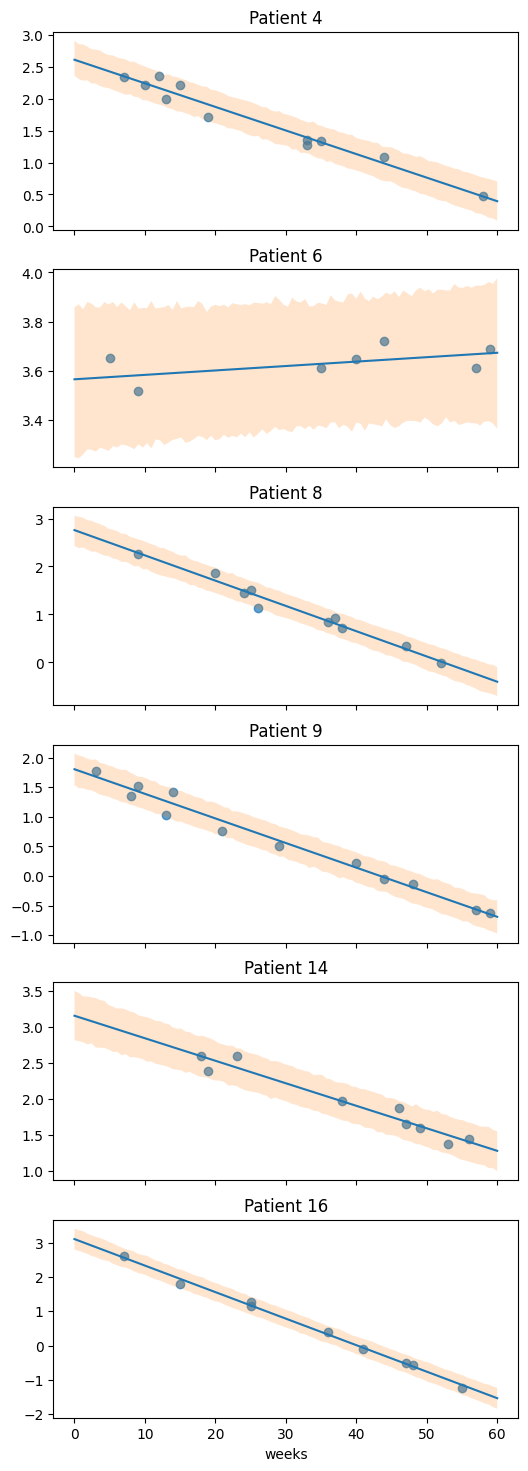

In [11]:

# Plot a few patients with posterior mean lines and predictive bands
J = int(pid.max()+1)
sel = np.sort(rng.choice(J, size=min(6, J), replace=False))
fig, axes = plt.subplots(len(sel), 1, figsize=(6, 3*len(sel)), sharex=True)
if len(sel)==1: axes = [axes]
for ax, j in zip(axes, sel):
    idx = pid==j
    tj = t[idx]; yj = yobs[idx]
    Bj_mean = Bj_draws.mean(axis=0)[j]
    ax.scatter(tj, yj, alpha=0.7)
    tg = np.linspace(0, 60, 100)
    mu = Bj_mean[0] + Bj_mean[1]*tg
    ax.plot(tg, mu)
    # predictive band using draws
    samp_idx = np.random.choice(len(Bj_draws), size=1000, replace=False)
    ypred = []
    for k in samp_idx:
        b0,b1 = Bj_draws[k,j]
        s2 = s2_draws[k]
        ypred.append(b0 + b1*tg + rng.normal(0, np.sqrt(s2), size=len(tg)))
    ypred = np.array(ypred)
    q = np.quantile(ypred, [0.05,0.95], axis=0)
    ax.fill_between(tg, q[0], q[1], alpha=0.2)
    ax.set_title(f"Patient {j}")
plt.xlabel("weeks"); plt.show()



### Shrinkage on slopes

Patients with few measurements have slope posteriors pulled more strongly toward the population mean.


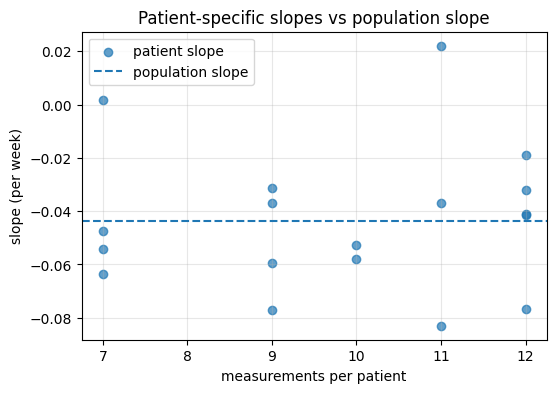

In [12]:

Bj_mean = Bj_draws.mean(axis=0)        # J x 2
beta_mean = beta_draws.mean(axis=0)    # population intercept, slope
meas_per_patient = np.array([np.sum(pid==j) for j in range(J)])

fig, ax = with_ax(title="Patient-specific slopes vs population slope", xlabel="measurements per patient", ylabel="slope (per week)")
ax.scatter(meas_per_patient, Bj_mean[:,1], alpha=0.7, label="patient slope")
ax.axhline(beta_mean[1], linestyle="--", label="population slope")
ax.legend(); plt.show()



## A note on collider bias

Be careful when conditioning on a downstream variable (e.g., studying only patients who already have the disease);
this can induce spurious associations (the **collider effect**).



## Key takeaways
- **Partial pooling** balances between complete pooling (high bias, low variance) and no pooling (low bias, high variance).  
- Hierarchical models yield **shrinkage** of group estimates toward the population, especially with few data per group.  
- Predicting **new-group** outcomes introduces extra uncertainty via the hyperparameters.  
- Random intercept-and-slope models capture both baseline and progression variations across individuals.
